id | atom_0 | atom_1 | bond_length | distance | H | C | N | neighbor_1 | neighbor_1_bond_length | neighbor_1_C | neighbor_1_H | neighbor_1_N | neighbor_2 | neighbor_2_bond_length | neighbor_2_C | neighbor_2_H | neighbor_2_N | neighbor_3 | neighbor_3_bond_length | neighbor_3_C | neighbor_3_H | neighbor_3_N | other_H | other_C | other_N | F | O

# Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting

from tqdm import tqdm_notebook as tqdm # progress bars

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Any results you write to the current directory are saved as output.

In [2]:
!dir '../input/champs-scalar-coupling/'

dipole_moments.csv		sample_submission.csv		   test.csv
magnetic_shielding_tensors.csv	scalar_coupling_contributions.csv  train.csv
mulliken_charges.csv		structures
potential_energy.csv		structures.csv


In [3]:
DATA_PATH = '../input/champs-scalar-coupling/'
GEOMETRY_DATA_PATH = '../input/simple-molecular-geometry-features/'

SUBMISSIONS_PATH = './'

RANDOM_SEED = 42

# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

ATOMIC_RADIUSES = { 'H': 0.38, 'C': 0.77, 'N': 0.75, 'O': 0.73, 'F': 0.71 }

ELECTRONEGATIVITY = { 'H': 2.2, 'C': 2.55, 'N': 3.04, 'O': 3.44, 'F': 3.98 }

FUDGE_FACTOR = 0.05

MAX_BONDS = 4

COUPLING_TYPES = ['1JHN', '1JHC', '2JHH', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']

COLUMNS_TO_PREDICT = ['fc', 'sd', 'pso','dso']

# Data Engineering

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling': 'float32',
}

contributions = pd.read_csv(f'{DATA_PATH}/train.csv', dtype=train_dtypes)
contributions['molecule_index'] = contributions['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
contributions['type_index'] = contributions['type'].str.split('J').str[0].astype('int8')
contributions = contributions.drop('molecule_name', axis=1)

In [5]:
contributions.head()

,id,atom_index_0,atom_index_1,type,scalar_coupling_constant,molecule_index,type_index
0,0,1,0,1JHC,84.8076,1,1
1,1,1,2,2JHH,-11.2570,1,2
2,2,1,3,2JHH,-11.2548,1,2
3,3,1,4,2JHH,-11.2543,1,2
4,4,2,0,1JHC,84.8074,1,1


In [6]:
test_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
}

test = pd.read_csv(f'{DATA_PATH}/test.csv', dtype=test_dtypes)
test['molecule_index'] = test['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test['type_index'] = test['type'].str.split('J').str[0].astype('int8')
test = test.drop('molecule_name', axis=1)

In [7]:
test.head()

,id,atom_index_0,atom_index_1,type,molecule_index,type_index
0,4658147,2,0,2JHC,4,2
1,4658148,2,1,1JHC,4,1
2,4658149,2,3,3JHH,4,3
3,4658150,3,0,1JHC,4,1
4,4658151,3,1,2JHC,4,2


In [8]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}

structures = pd.read_csv(f'{DATA_PATH}structures.csv', dtype=structures_dtypes)
structures['molecule_index'] = structures['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
structures = structures.drop('molecule_name', axis=1)

In [9]:
structures.head()

,atom_index,atom,x,y,z,molecule_index
0,0,C,-0.012698,1.085804,0.008001,1
1,1,H,0.002150,-0.006031,0.001976,1
2,2,H,1.011731,1.463751,0.000277,1
3,3,H,-0.540815,1.447527,-0.876644,1
4,4,H,-0.523814,1.437933,0.906397,1


## Geometry

In [10]:
!dir '../input/simple-molecular-geometry-features/'

test_geom.csv  train_geom.csv


In [11]:
geometry_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'num_atoms': 'int8',
    'flatness_metric': 'float32',
    'bond_angle_plane': 'float32',
    'bond_angle_axis': 'float32'
}

In [12]:
train_geometry = pd.read_csv(f'{GEOMETRY_DATA_PATH}train_geom.csv', dtype=geometry_dtypes)

In [13]:
test_geometry = pd.read_csv(f'{GEOMETRY_DATA_PATH}/test_geom.csv', dtype=geometry_dtypes)

In [14]:
train_geometry.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,5,0.443763,52.084335,34.460724
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,5,0.443763,73.351372,0.804151
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,5,0.443763,39.073647,44.696644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,5,0.443763,20.124275,44.160492
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,5,0.443763,50.858952,36.069061


## Atoms Count

In [15]:
structure_atom_groups = structures.groupby(['molecule_index'])['atom'].value_counts().to_frame()
structure_atom_groups = structure_atom_groups.rename(columns={'atom': 'atoms_count'}, inplace=False).astype('int8').reset_index()

In [16]:
structure_atom_groups.head()

,molecule_index,atom,atoms_count
0,1,H,4
1,1,C,1
2,2,H,3
3,2,N,1
4,3,H,2


In [17]:
molecules_atom_counts = structure_atom_groups.pivot(index='molecule_index', columns='atom', values='atoms_count').reset_index().reset_index(drop=True)
molecules_atom_counts.columns.name = ''
molecules_atom_counts = molecules_atom_counts.fillna(0)

for atom_type in ATOMIC_NUMBERS.keys():
    molecules_atom_counts[atom_type] = molecules_atom_counts[atom_type].astype('int8')

molecules_atom_counts.head()

,molecule_index,C,F,H,N,O
0,1,1,0,4,0,0
1,2,0,0,3,1,0
2,3,0,0,2,0,1
3,4,2,0,2,0,0
4,5,1,0,1,1,0


## Bonds

In [18]:
atoms = structures['atom'].values
atoms_en = [ELECTRONEGATIVITY[x] for x in tqdm(atoms)]
atoms_rad = [ATOMIC_RADIUSES[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

structures['atom'] = structures['atom'].replace(ATOMIC_NUMBERS).astype('int8')

In [19]:
structures.head()

,atom_index,atom,x,y,z,molecule_index,EN,rad
0,0,6,-0.012698,1.085804,0.008001,1,2.55,0.77
1,1,1,0.002150,-0.006031,0.001976,1,2.20,0.38
2,2,1,1.011731,1.463751,0.000277,1,2.20,0.38
3,3,1,-0.540815,1.447527,-0.876644,1,2.20,0.38
4,4,1,-0.523814,1.437933,0.906397,1,2.20,0.38


In [20]:
i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_index'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')
bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]

print('Forming DF columns:')
bonds_data = pd.DataFrame()

for i in range(MAX_BONDS):
    print(f'Neighbor #{i}:')    

    bonds_data[f'neighbor_{i}_index'] = [int(row[i]) if i < len(row) else -1 for row in tqdm(bonds_numeric)]
    bonds_data[f'neighbor_{i}_bond_length'] = [row[i] if i < len(row) else 0.0 for row in tqdm(bond_lengths)]
    
    bonds_data[f'neighbor_{i}_index'] = bonds_data[f'neighbor_{i}_index'].astype('int8')
    bonds_data[f'neighbor_{i}_bond_length'] = bonds_data[f'neighbor_{i}_bond_length'].astype('float32')
    
bonds_data['bonds_count'] = [len(x) for x in bonds_numeric]

Calculating bonds



Counting and condensing bonds



Forming DF columns:
Neighbor #0:



Neighbor #1:



Neighbor #2:



Neighbor #3:


In [21]:
bonds_data.head()

,neighbor_0_index,neighbor_0_bond_length,neighbor_1_index,neighbor_1_bond_length,neighbor_2_index,neighbor_2_bond_length,neighbor_3_index,neighbor_3_bond_length,bonds_count
0,1,1.091953,2,1.091952,3,1.091946,4,1.091948,4
1,0,1.091953,-1,0.000000,-1,0.000000,-1,0.000000,1
2,0,1.091952,-1,0.000000,-1,0.000000,-1,0.000000,1
3,0,1.091946,-1,0.000000,-1,0.000000,-1,0.000000,1
4,0,1.091948,-1,0.000000,-1,0.000000,-1,0.000000,1


In [22]:
neighbor_structures = structures.join(bonds_data)

In [23]:
for i in range(4):
    neighbor_structures = neighbor_structures.merge(structures[['molecule_index', 'atom_index', 'atom']], how='left', left_on=['molecule_index', f'neighbor_{i}_index'], right_on=['molecule_index', 'atom_index'], copy=False)
    
    neighbor_structures = neighbor_structures.rename(columns={'atom_index_x': f'atom_index', 'atom_x': 'atom', 'atom_y': f'neighbor_{i}_atom'})
    neighbor_structures = neighbor_structures.drop('atom_index_y', axis=1)

In [24]:
neighbor_structures.columns

Index(['atom_index', 'atom', 'x', 'y', 'z', 'molecule_index', 'EN', 'rad',
       'neighbor_0_index', 'neighbor_0_bond_length', 'neighbor_1_index',
       'neighbor_1_bond_length', 'neighbor_2_index', 'neighbor_2_bond_length',
       'neighbor_3_index', 'neighbor_3_bond_length', 'bonds_count',
       'neighbor_0_atom', 'neighbor_1_atom', 'neighbor_2_atom',
       'neighbor_3_atom'],
      dtype='object')

In [25]:
for atom in ATOMIC_NUMBERS.keys():
    neighbor_structures[f'{atom}_count'] = np.sum([neighbor_structures[f'neighbor_{i}_atom'] == ATOMIC_NUMBERS[atom] for i in range(MAX_BONDS)], axis=0)
    neighbor_structures.loc[neighbor_structures[f'{atom}_count'] > 0, f'{atom}_bonds_length_mean'] = np.nanmean(pd.concat([neighbor_structures.loc[neighbor_structures[f'neighbor_{i}_atom'] == ATOMIC_NUMBERS[atom], f'neighbor_{i}_bond_length'] for i in range(MAX_BONDS)], axis=1), axis=1)
    neighbor_structures[f'{atom}_bonds_length_mean'] = neighbor_structures[f'{atom}_bonds_length_mean'].fillna(0)

In [26]:
neighbor_structures.head(25)

,atom_index,atom,x,y,z,molecule_index,EN,rad,neighbor_0_index,neighbor_0_bond_length,...,H_count,H_bonds_length_mean,C_count,C_bonds_length_mean,N_count,N_bonds_length_mean,O_count,O_bonds_length_mean,F_count,F_bonds_length_mean
0,0,6,-0.012698,1.085804,0.008001,1,2.55,0.77,1,1.091953,...,4,1.091950,0,0.000000,0,0.000000,0,0.000000,0,0.0
1,1,1,0.002150,-0.006031,0.001976,1,2.20,0.38,0,1.091953,...,0,0.000000,1,1.091953,0,0.000000,0,0.000000,0,0.0
2,2,1,1.011731,1.463751,0.000277,1,2.20,0.38,0,1.091952,...,0,0.000000,1,1.091952,0,0.000000,0,0.000000,0,0.0
3,3,1,-0.540815,1.447527,-0.876644,1,2.20,0.38,0,1.091946,...,0,0.000000,1,1.091946,0,0.000000,0,0.000000,0,0.0
4,4,1,-0.523814,1.437933,0.906397,1,2.20,0.38,0,1.091948,...,0,0.000000,1,1.091948,0,0.000000,0,0.000000,0,0.0
5,0,7,-0.040426,1.024108,0.062564,2,3.04,0.75,1,1.017190,...,3,1.017195,0,0.000000,0,0.000000,0,0.000000,0,0.0
6,1,1,0.017257,0.012545,-0.027377,2,2.20,0.38,0,1.017190,...,0,0.000000,0,0.000000,1,1.017190,0,0.000000,0,0.0
7,2,1,0.915789,1.358745,-0.028758,2,2.20,0.38,0,1.017187,...,0,0.000000,0,0.000000,1,1.017187,0,0.000000,0,0.0
8,3,1,-0.520278,1.343532,-0.775543,2,2.20,0.38,0,1.017208,...,0,0.000000,0,0.000000,1,1.017208,0,0.000000,0,0.0
9,0,8,-0.034360,0.977540,0.007602,3,3.44,0.73,1,0.962107,...,2,0.962107,0,0.000000,0,0.000000,0,0.000000,0,0.0


In [27]:
neighbor_structures.columns

Index(['atom_index', 'atom', 'x', 'y', 'z', 'molecule_index', 'EN', 'rad',
       'neighbor_0_index', 'neighbor_0_bond_length', 'neighbor_1_index',
       'neighbor_1_bond_length', 'neighbor_2_index', 'neighbor_2_bond_length',
       'neighbor_3_index', 'neighbor_3_bond_length', 'bonds_count',
       'neighbor_0_atom', 'neighbor_1_atom', 'neighbor_2_atom',
       'neighbor_3_atom', 'H_count', 'H_bonds_length_mean', 'C_count',
       'C_bonds_length_mean', 'N_count', 'N_bonds_length_mean', 'O_count',
       'O_bonds_length_mean', 'F_count', 'F_bonds_length_mean'],
      dtype='object')

## Feature Engineering

In [28]:
def process_dataset(df, structures):
    for i in range(2):
        df = pd.merge(df, structures, how='left', left_on=['molecule_index', f'atom_index_{i}'], right_on=['molecule_index', 'atom_index'])

        df = df.drop('atom_index', axis=1)

        df = df.rename(columns={
                                'atom': f'atom_{i}',
                                'rad': f'radii_{i}',
                                'EN': f'electronegativity_{i}',
            
                                'x': f'x_{i}',
                                'y': f'y_{i}',
                                'z': f'z_{i}',
            
                                'bonds_count': f'bonds_count_{i}',
            
                                'H_count': f'H_count_{i}',
                                'C_count': f'C_count_{i}',
                                'N_count': f'N_count_{i}',
                                'O_count': f'O_count_{i}',
                                'F_count': f'F_count_{i}',
            
                                'H_bonds_length_mean': f'H_bonds_length_mean_{i}',
                                'C_bonds_length_mean': f'C_bonds_length_mean_{i}',
                                'N_bonds_length_mean': f'N_bonds_length_mean_{i}',
                                'O_bonds_length_mean': f'O_bonds_length_mean_{i}',
                                'F_bonds_length_mean': f'F_bonds_length_mean_{i}',
                               })

        df[f'atom_{i}_bonds_mean'] = np.nanmean([df[f'neighbor_{j}_bond_length'] for j in range(MAX_BONDS)], axis=0)
        df = df.drop([f'neighbor_{j}_bond_length' for j in range(MAX_BONDS)] + [f'neighbor_{j}_index' for j in range(MAX_BONDS)] + [f'neighbor_{j}_atom' for j in range(MAX_BONDS)], axis=1)

        df = df.drop(f'atom_index_{i}', axis=1)

    return df

In [29]:
df = process_dataset(contributions, neighbor_structures)

In [30]:
df.head(25)

,id,type,scalar_coupling_constant,molecule_index,type_index,atom_0,x_0,y_0,z_0,electronegativity_0,...,H_bonds_length_mean_1,C_count_1,C_bonds_length_mean_1,N_count_1,N_bonds_length_mean_1,O_count_1,O_bonds_length_mean_1,F_count_1,F_bonds_length_mean_1,atom_1_bonds_mean
0,0,1JHC,84.80760,1,1,1,0.002150,-0.006031,0.001976,2.2,...,1.091950,0,0.000000,0,0.000000,0,0.000000,0,0.0,1.091950
1,1,2JHH,-11.25700,1,2,1,0.002150,-0.006031,0.001976,2.2,...,0.000000,1,1.091952,0,0.000000,0,0.000000,0,0.0,0.272988
2,2,2JHH,-11.25480,1,2,1,0.002150,-0.006031,0.001976,2.2,...,0.000000,1,1.091946,0,0.000000,0,0.000000,0,0.0,0.272987
3,3,2JHH,-11.25430,1,2,1,0.002150,-0.006031,0.001976,2.2,...,0.000000,1,1.091948,0,0.000000,0,0.000000,0,0.0,0.272987
4,4,1JHC,84.80740,1,1,1,1.011731,1.463751,0.000277,2.2,...,1.091950,0,0.000000,0,0.000000,0,0.000000,0,0.0,1.091950
5,5,2JHH,-11.25410,1,2,1,1.011731,1.463751,0.000277,2.2,...,0.000000,1,1.091946,0,0.000000,0,0.000000,0,0.0,0.272987
6,6,2JHH,-11.25480,1,2,1,1.011731,1.463751,0.000277,2.2,...,0.000000,1,1.091948,0,0.000000,0,0.000000,0,0.0,0.272987
7,7,1JHC,84.80930,1,1,1,-0.540815,1.447527,-0.876644,2.2,...,1.091950,0,0.000000,0,0.000000,0,0.000000,0,0.0,1.091950
8,8,2JHH,-11.25430,1,2,1,-0.540815,1.447527,-0.876644,2.2,...,0.000000,1,1.091948,0,0.000000,0,0.000000,0,0.0,0.272987
9,9,1JHC,84.80950,1,1,1,-0.523814,1.437933,0.906397,2.2,...,1.091950,0,0.000000,0,0.000000,0,0.000000,0,0.0,1.091950


In [31]:
test_df = process_dataset(test, neighbor_structures)

In [32]:
test_df.head()

,id,type,molecule_index,type_index,atom_0,x_0,y_0,z_0,electronegativity_0,radii_0,...,H_bonds_length_mean_1,C_count_1,C_bonds_length_mean_1,N_count_1,N_bonds_length_mean_1,O_count_1,O_bonds_length_mean_1,F_count_1,F_bonds_length_mean_1,atom_1_bonds_mean
0,4658147,2JHC,4,2,1,-1.661639,0.0,1.0,2.2,0.38,...,1.062099,1,1.199079,0,0.0,0,0.0,0,0.0,0.565295
1,4658148,1JHC,4,1,1,-1.661639,0.0,1.0,2.2,0.38,...,1.062099,1,1.199079,0,0.0,0,0.0,0,0.0,0.565295
2,4658149,3JHH,4,3,1,-1.661639,0.0,1.0,2.2,0.38,...,0.000000,1,1.062099,0,0.0,0,0.0,0,0.0,0.265525
3,4658150,1JHC,4,1,1,1.661639,0.0,1.0,2.2,0.38,...,1.062099,1,1.199079,0,0.0,0,0.0,0,0.0,0.565295
4,4658151,2JHC,4,2,1,1.661639,0.0,1.0,2.2,0.38,...,1.062099,1,1.199079,0,0.0,0,0.0,0,0.0,0.565295


In [33]:
def calculate_distance_3d(x0, y0, z0, x1, y1, z1):
  return np.sqrt(np.multiply((x1 - x0), (x1 - x0)) + np.multiply((y1 - y0), (y1 - y0)) + np.multiply((z1 - z0), (z1 - z0)))

In [34]:
def calculate_distance_for_df(df):
    df['distance'] = calculate_distance_3d(df['x_0'], df['y_0'], df['z_0'], df['x_1'], df['y_1'], df['z_1']).astype('float32')
    df = df.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    
    return df

In [35]:
df = calculate_distance_for_df(df)

In [36]:
test_df = calculate_distance_for_df(test_df)

In [37]:
test_df.head()

,id,type,molecule_index,type_index,atom_0,electronegativity_0,radii_0,bonds_count_0,H_count_0,H_bonds_length_mean_0,...,C_count_1,C_bonds_length_mean_1,N_count_1,N_bonds_length_mean_1,O_count_1,O_bonds_length_mean_1,F_count_1,F_bonds_length_mean_1,atom_1_bonds_mean,distance
0,4658147,2JHC,4,2,1,2.2,0.38,1,0,0.0,...,1,1.199079,0,0.0,0,0.0,0,0.0,0.565295,2.261178
1,4658148,1JHC,4,1,1,2.2,0.38,1,0,0.0,...,1,1.199079,0,0.0,0,0.0,0,0.0,0.565295,1.062099
2,4658149,3JHH,4,3,1,2.2,0.38,1,0,0.0,...,1,1.062099,0,0.0,0,0.0,0,0.0,0.265525,3.323277
3,4658150,1JHC,4,1,1,2.2,0.38,1,0,0.0,...,1,1.199079,0,0.0,0,0.0,0,0.0,0.565295,1.062099
4,4658151,2JHC,4,2,1,2.2,0.38,1,0,0.0,...,1,1.199079,0,0.0,0,0.0,0,0.0,0.565295,2.261178


In [38]:
# df = pd.merge(df, molecules_atom_counts, how='left', left_on=['molecule_index'], right_on=['molecule_index'])

In [39]:
# test_df = pd.merge(test_df, molecules_atom_counts, how='left', left_on=['molecule_index'], right_on=['molecule_index'])

In [40]:
def add_types_count(df):
    type_groups = df.groupby(['molecule_index'])['type'].value_counts().to_frame()
    type_groups = type_groups.rename(columns={'type': 'types_count'}, inplace=False).astype('int8').reset_index()

    molecule_types_count = type_groups.pivot(index='molecule_index', columns='type', values='types_count').reset_index().reset_index(drop=True)
    # train_types_count.columns.name = 'molecules'
    molecule_types_count = molecule_types_count.fillna(0)
    
    for coupling_type in COUPLING_TYPES:
        molecule_types_count[coupling_type] = molecule_types_count[coupling_type].astype('int8')
    
    return pd.merge(df, molecule_types_count, how='left', left_on=['molecule_index'], right_on=['molecule_index'])

In [41]:
# df = add_types_count(df)
# test_df = add_types_count(test_df)

In [42]:
df.head()

,id,type,scalar_coupling_constant,molecule_index,type_index,atom_0,electronegativity_0,radii_0,bonds_count_0,H_count_0,...,C_count_1,C_bonds_length_mean_1,N_count_1,N_bonds_length_mean_1,O_count_1,O_bonds_length_mean_1,F_count_1,F_bonds_length_mean_1,atom_1_bonds_mean,distance
0,0,1JHC,84.8076,1,1,1,2.2,0.38,1,0,...,0,0.000000,0,0.0,0,0.0,0,0.0,1.091950,1.091953
1,1,2JHH,-11.2570,1,2,1,2.2,0.38,1,0,...,1,1.091952,0,0.0,0,0.0,0,0.0,0.272988,1.783120
2,2,2JHH,-11.2548,1,2,1,2.2,0.38,1,0,...,1,1.091946,0,0.0,0,0.0,0,0.0,0.272987,1.783147
3,3,2JHH,-11.2543,1,2,1,2.2,0.38,1,0,...,1,1.091948,0,0.0,0,0.0,0,0.0,0.272987,1.783157
4,4,1JHC,84.8074,1,1,1,2.2,0.38,1,0,...,0,0.000000,0,0.0,0,0.0,0,0.0,1.091950,1.091952


In [43]:
df.tail()

,id,type,scalar_coupling_constant,molecule_index,type_index,atom_0,electronegativity_0,radii_0,bonds_count_0,H_count_0,...,C_count_1,C_bonds_length_mean_1,N_count_1,N_bonds_length_mean_1,O_count_1,O_bonds_length_mean_1,F_count_1,F_bonds_length_mean_1,atom_1_bonds_mean,distance
4658142,4658142,2JHC,3.543450,133884,2,1,2.2,0.38,1,0,...,2,1.532830,0,0.0,0,0.0,0,0.0,1.037270,2.306538
4658143,4658143,3JHC,0.568997,133884,3,1,2.2,0.38,1,0,...,1,1.520007,0,0.0,0,0.0,0,0.0,0.927148,3.495226
4658144,4658144,3JHC,1.173370,133884,3,1,2.2,0.38,1,0,...,1,1.520007,0,0.0,0,0.0,0,0.0,0.380002,3.397424
4658145,4658145,2JHC,4.762010,133884,2,1,2.2,0.38,1,0,...,1,1.509930,0,0.0,0,0.0,0,0.0,0.650102,2.312202
4658146,4658146,1JHC,117.934000,133884,1,1,2.2,0.38,1,0,...,3,1.517490,0,0.0,0,0.0,0,0.0,1.408367,1.080997


In [44]:
geometry_columns = ['num_atoms', 'flatness_metric', 'bond_angle_plane', 'bond_angle_axis']

df = df.join(train_geometry[geometry_columns])
test_df = test_df.join(test_geometry[geometry_columns])

In [45]:
test_df.columns

Index(['id', 'type', 'molecule_index', 'type_index', 'atom_0',
       'electronegativity_0', 'radii_0', 'bonds_count_0', 'H_count_0',
       'H_bonds_length_mean_0', 'C_count_0', 'C_bonds_length_mean_0',
       'N_count_0', 'N_bonds_length_mean_0', 'O_count_0',
       'O_bonds_length_mean_0', 'F_count_0', 'F_bonds_length_mean_0',
       'atom_0_bonds_mean', 'atom_1', 'electronegativity_1', 'radii_1',
       'bonds_count_1', 'H_count_1', 'H_bonds_length_mean_1', 'C_count_1',
       'C_bonds_length_mean_1', 'N_count_1', 'N_bonds_length_mean_1',
       'O_count_1', 'O_bonds_length_mean_1', 'F_count_1',
       'F_bonds_length_mean_1', 'atom_1_bonds_mean', 'distance', 'num_atoms',
       'flatness_metric', 'bond_angle_plane', 'bond_angle_axis'],
      dtype='object')

## Data Grouping

In [46]:
groups = df.groupby('type')

In [47]:
data_dict = {}

for name, group in groups:
    data_dict[name] = group.iloc[:, group.columns != 'type']

In [48]:
data_dict['1JHC'].head()

,id,scalar_coupling_constant,molecule_index,type_index,atom_0,electronegativity_0,radii_0,bonds_count_0,H_count_0,H_bonds_length_mean_0,...,O_count_1,O_bonds_length_mean_1,F_count_1,F_bonds_length_mean_1,atom_1_bonds_mean,distance,num_atoms,flatness_metric,bond_angle_plane,bond_angle_axis
0,0,84.8076,1,1,1,2.2,0.38,1,0,0.0,...,0,0.0,0,0.0,1.091950,1.091953,5,0.443763,52.084335,34.460724
4,4,84.8074,1,1,1,2.2,0.38,1,0,0.0,...,0,0.0,0,0.0,1.091950,1.091952,5,0.443763,50.858952,36.069061
7,7,84.8093,1,1,1,2.2,0.38,1,0,0.0,...,0,0.0,0,0.0,1.091950,1.091946,5,0.443763,13.909506,35.642807
9,9,84.8095,1,1,1,2.2,0.38,1,0,0.0,...,0,0.0,0,0.0,1.091950,1.091948,5,0.443763,13.124758,34.877453
17,17,171.2200,5,1,1,2.2,0.38,1,0,0.0,...,0,0.0,0,0.0,0.554587,1.066598,3,NaN,NaN,NaN


In [49]:
# for key in data_dict.keys():
#   series = pd.Series(data_dict[key]['scalar_coupling_constant'])
#   series.plot.box()
#   plt.title(key)
#   plt.figure()

# Models

In [50]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

In [51]:
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.3,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 8,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [52]:
skip_columns = [key for key in ATOMIC_NUMBERS.keys()] + COUPLING_TYPES

In [53]:
skip_columns

['H',
 'C',
 'N',
 'O',
 'F',
 '1JHN',
 '1JHC',
 '2JHH',
 '2JHN',
 '2JHC',
 '3JHH',
 '3JHC',
 '3JHN']

In [54]:
def build_dataset(df, coupling_type):
    type_df = df[df['type'] == coupling_type]
    column = 'scalar_coupling_constant'
    
    if column in type_df:
        X_data = type_df.drop(column, axis=1)
        y_data = type_df[column].values.astype('float32')
    else:
        X_data = type_df
        y_data = None
        
    if 'id' in type_df:
        X_data = X_data.drop('id', axis=1)
        
    if 'molecule_index' in type_df:
        X_data = X_data.drop('molecule_index', axis=1)
    
#     X_data = X_data.drop(skip_columns, axis=1)
    return X_data, y_data, type_df.index.values

In [55]:
def train_and_predict(coupling_type, submission, n_folds=2, n_splits=5, random_state=RANDOM_SEED):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data, groups = build_dataset(df, coupling_type)
    X_test, _, __ = build_dataset(test_df, coupling_type)
    
    y_pred = np.zeros(X_test.shape[0], dtype='float32')
    
    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break
        
        X_train, X_val = X_data.iloc[train_index], X_data.iloc[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=10000, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=500, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        print(y_val)
        print(y_val_pred)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
                
        feature_importance = lgb.plot_importance(model, max_num_features=20)
        feature_importance.set_title(f'{coupling_type} | Feature Importance')
        plt.show()
        plt.figure()
        
    submission.loc[test_df['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score, submission

In [56]:
# Preparing empty submission file
submission = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
submission.head()

,id,scalar_coupling_constant
0,4658147,0
1,4658148,0
2,4658149,0
3,4658150,0
4,4658151,0


Predicting for: 1JHN
*** Training Model for 1JHN ***
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.599123	valid_1's l1: 0.943233
Early stopping, best iteration is:
[592]	training's l1: 0.560653	valid_1's l1: 0.942734
[32.6889 32.6891 54.7359 ... 55.9156 57.2586 36.526 ]
[40.48325931 40.68376643 57.14412212 ... 55.01465033 56.58554926
 34.33589956]
1JHN Fold 0, logMAE: -0.0589712947752292


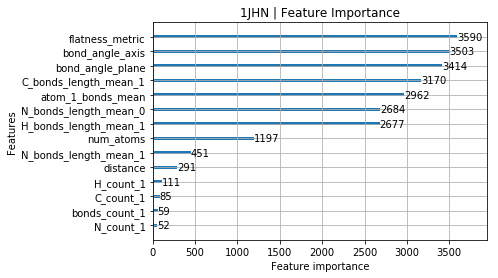

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.598023	valid_1's l1: 0.935894
Early stopping, best iteration is:
[463]	training's l1: 0.615353	valid_1's l1: 0.934744
[56.186  50.6896 47.3658 ... 34.5596 55.1705 44.0682]
[56.72115373 51.35528969 47.97017047 ... 36.57505836 55.85243092
 44.29639452]
1JHN Fold 1, logMAE: -0.06748309414744316


<Figure size 432x288 with 0 Axes>

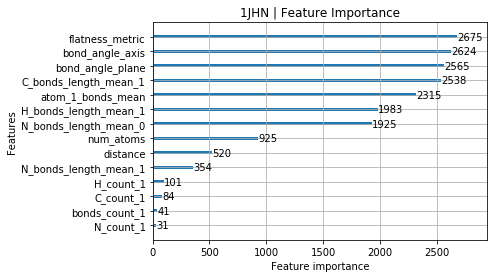

Predicting for: 1JHC
*** Training Model for 1JHC ***
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.86603	valid_1's l1: 2.09656
[1000]	training's l1: 1.68327	valid_1's l1: 2.07322
[1500]	training's l1: 1.54669	valid_1's l1: 2.06881
Early stopping, best iteration is:
[1719]	training's l1: 1.49287	valid_1's l1: 2.06704
[ 83.5417  83.5484  83.543  ... 100.769  103.633   87.8911]
[83.96866743 81.80062685 83.59986294 ... 96.21623425 91.16228469
 86.47203857]
1JHC Fold 0, logMAE: 0.7261179120951499


<Figure size 432x288 with 0 Axes>

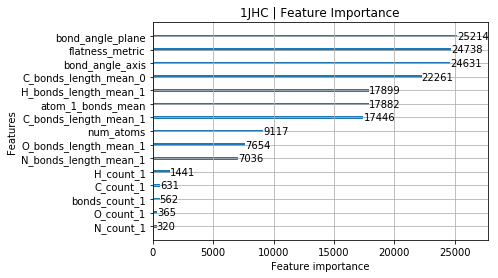

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.86141	valid_1's l1: 2.10625
[1000]	training's l1: 1.68169	valid_1's l1: 2.08384
[1500]	training's l1: 1.5456	valid_1's l1: 2.07676
Early stopping, best iteration is:
[1359]	training's l1: 1.57883	valid_1's l1: 2.07598
[ 84.8076  84.8093  87.6326 ...  95.6543 116.136  117.934 ]
[ 88.10465697  82.89550809  91.77824356 ...  95.37644248  99.89653162
 117.06764032]
1JHC Fold 1, logMAE: 0.7304341206943267


<Figure size 432x288 with 0 Axes>

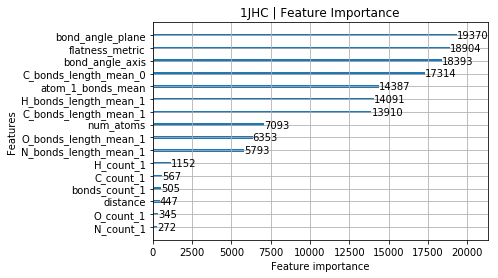

Predicting for: 2JHH
*** Training Model for 2JHH ***
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.61443	valid_1's l1: 0.737342
Early stopping, best iteration is:
[509]	training's l1: 0.612875	valid_1's l1: 0.737265
[-11.2543  -11.1757   -6.48291 ... -11.6731   -8.29155  -1.4487 ]
[-11.17130038  -9.98388157  -7.54239989 ... -11.75986115  -6.16201231
  -2.43261756]
2JHH Fold 0, logMAE: -0.30480761540721923


<Figure size 432x288 with 0 Axes>

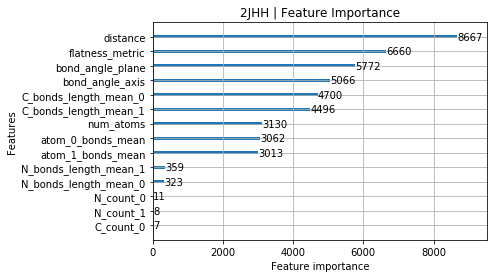

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.614287	valid_1's l1: 0.73713
Early stopping, best iteration is:
[456]	training's l1: 0.622439	valid_1's l1: 0.736685
[-11.257   -11.1866  -11.6979  ...  -2.38804  -7.87529  -9.19911]
[-11.1886222  -10.61625705 -11.81031992 ...  -4.2091755   -8.25954917
  -8.70543686]
2JHH Fold 1, logMAE: -0.3055949685735325


<Figure size 432x288 with 0 Axes>

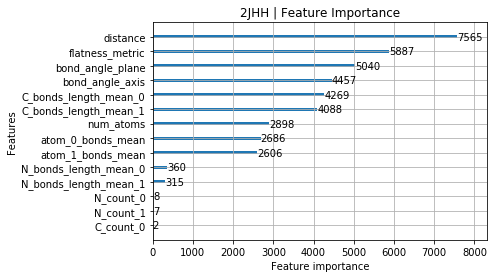

Predicting for: 2JHN
*** Training Model for 2JHN ***
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.388697	valid_1's l1: 0.58521
[1000]	training's l1: 0.290769	valid_1's l1: 0.58015
Early stopping, best iteration is:
[897]	training's l1: 0.307357	valid_1's l1: 0.579649
[ 5.18246  1.3783  -1.82873 ...  7.87989  6.71047  3.71925]
[ 3.96369525  2.18969016 -1.50361989 ...  5.50165532  5.16949523
  2.99582295]
2JHN Fold 0, logMAE: -0.5453330403221616


<Figure size 432x288 with 0 Axes>

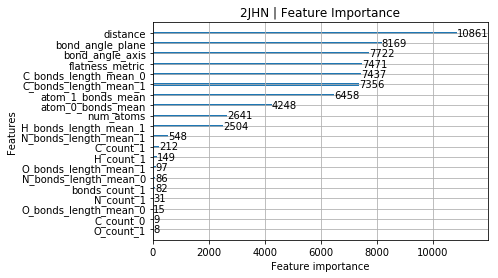

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.386794	valid_1's l1: 0.583826
[1000]	training's l1: 0.290351	valid_1's l1: 0.581725
Early stopping, best iteration is:
[885]	training's l1: 0.309238	valid_1's l1: 0.581038
[ 9.05653 11.371    6.3172  ...  8.05603  5.87521  2.09636]
[ 8.78709438 11.22266989  5.64739437 ...  4.90844126  5.72256482
  2.00266468]
2JHN Fold 1, logMAE: -0.5429387441771345


<Figure size 432x288 with 0 Axes>

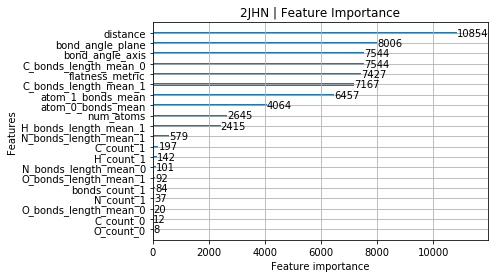

Predicting for: 2JHC
*** Training Model for 2JHC ***
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.915425	valid_1's l1: 1.01501
[1000]	training's l1: 0.819536	valid_1's l1: 0.982954
[1500]	training's l1: 0.754251	valid_1's l1: 0.970484
[2000]	training's l1: 0.699124	valid_1's l1: 0.963091
[2500]	training's l1: 0.653954	valid_1's l1: 0.959252
[3000]	training's l1: 0.614595	valid_1's l1: 0.957048
[3500]	training's l1: 0.579334	valid_1's l1: 0.955761
[4000]	training's l1: 0.547211	valid_1's l1: 0.955077
Early stopping, best iteration is:
[3967]	training's l1: 0.549326	valid_1's l1: 0.955041
[-2.37831  -2.37716  -2.37724  ... -1.77742   0.861393  0.31829 ]
[-2.34320311 -2.59905804 -2.59905804 ... -2.14221578  1.59342684
  0.41908243]
2JHC Fold 0, logMAE: -0.046001147891126526


<Figure size 432x288 with 0 Axes>

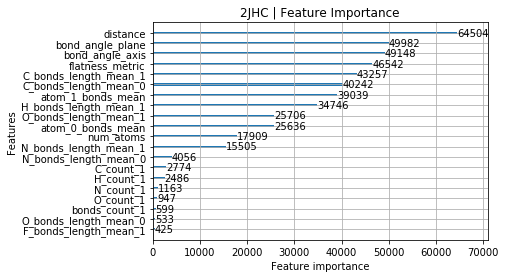

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.912088	valid_1's l1: 1.01206
[1000]	training's l1: 0.817861	valid_1's l1: 0.981321
[1500]	training's l1: 0.752389	valid_1's l1: 0.968506
[2000]	training's l1: 0.698218	valid_1's l1: 0.961626
[2500]	training's l1: 0.65314	valid_1's l1: 0.95823
[3000]	training's l1: 0.613545	valid_1's l1: 0.956092
[3500]	training's l1: 0.578217	valid_1's l1: 0.955117
[4000]	training's l1: 0.546195	valid_1's l1: 0.954363
[4500]	training's l1: 0.517101	valid_1's l1: 0.953874
[5000]	training's l1: 0.490504	valid_1's l1: 0.953829
Early stopping, best iteration is:
[4831]	training's l1: 0.499251	valid_1's l1: 0.953546
[-2.37876  19.9423   31.7736   ... -1.14866   0.861412  3.54345 ]
[-1.71007973 19.73397169 27.26045885 ... -1.06238462  1.93966654
  3.72796826]
2JHC Fold 1, logMAE: -0.04756757942635786


<Figure size 432x288 with 0 Axes>

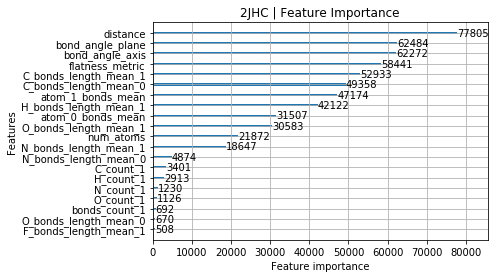

Predicting for: 3JHH
*** Training Model for 3JHH ***
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.657424	valid_1's l1: 0.75564
[1000]	training's l1: 0.583131	valid_1's l1: 0.752553
Early stopping, best iteration is:
[946]	training's l1: 0.589975	valid_1's l1: 0.752033
[ 3.25281   3.25205   3.25243  ... -0.241971 -0.637186  0.789559]
[ 3.36214894  3.40542753  3.18742375 ... -0.23110397 -0.17850659
  0.81155152]
3JHH Fold 0, logMAE: -0.2849752410791904


<Figure size 432x288 with 0 Axes>

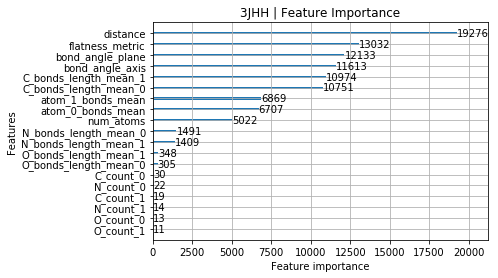

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.655721	valid_1's l1: 0.75387
[1000]	training's l1: 0.5826	valid_1's l1: 0.750725
Early stopping, best iteration is:
[863]	training's l1: 0.600329	valid_1's l1: 0.750299
[ 0.188092  3.42924  11.4717   ...  0.372757  3.06288   3.06282 ]
[ 0.77541698  3.76179624 12.33386137 ...  1.07520733  2.96349084
  3.43655593]
3JHH Fold 1, logMAE: -0.2872832019137944


<Figure size 432x288 with 0 Axes>

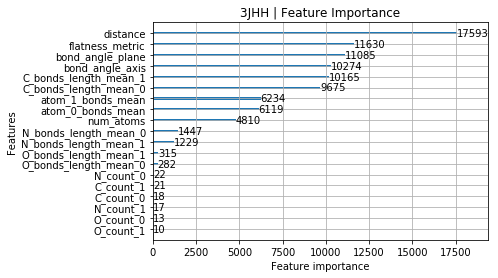

Predicting for: 3JHC
*** Training Model for 3JHC ***
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.98053	valid_1's l1: 1.06542
[1000]	training's l1: 0.884738	valid_1's l1: 1.02322
[1500]	training's l1: 0.819096	valid_1's l1: 1.00467
[2000]	training's l1: 0.767286	valid_1's l1: 0.994478
[2500]	training's l1: 0.722522	valid_1's l1: 0.986681
[3000]	training's l1: 0.683194	valid_1's l1: 0.981383
[3500]	training's l1: 0.648481	valid_1's l1: 0.977172
[4000]	training's l1: 0.616918	valid_1's l1: 0.974223
[4500]	training's l1: 0.588262	valid_1's l1: 0.97302
[5000]	training's l1: 0.561723	valid_1's l1: 0.971065
[5500]	training's l1: 0.53727	valid_1's l1: 0.969859
[6000]	training's l1: 0.514584	valid_1's l1: 0.968744
[6500]	training's l1: 0.493338	valid_1's l1: 0.968003
[7000]	training's l1: 0.473557	valid_1's l1: 0.967533
[7500]	training's l1: 0.455004	valid_1's l1: 0.967127
[8000]	training's l1: 0.437737	valid_1's l1: 0.966893
Early stopping, best iterat

<Figure size 432x288 with 0 Axes>

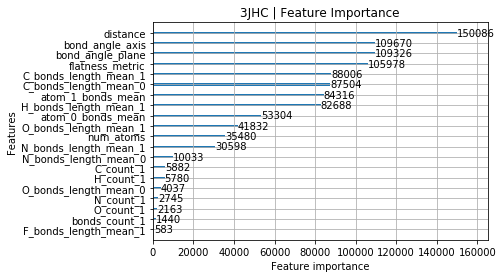

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.979406	valid_1's l1: 1.05762
[1000]	training's l1: 0.883426	valid_1's l1: 1.01852
[1500]	training's l1: 0.818595	valid_1's l1: 1.00008
[2000]	training's l1: 0.766424	valid_1's l1: 0.989838
[2500]	training's l1: 0.721245	valid_1's l1: 0.983143
[3000]	training's l1: 0.682263	valid_1's l1: 0.978317
[3500]	training's l1: 0.647531	valid_1's l1: 0.97466
[4000]	training's l1: 0.616247	valid_1's l1: 0.97179
[4500]	training's l1: 0.587852	valid_1's l1: 0.970131
[5000]	training's l1: 0.561433	valid_1's l1: 0.968566
[5500]	training's l1: 0.537137	valid_1's l1: 0.967616
[6000]	training's l1: 0.514296	valid_1's l1: 0.966705
[6500]	training's l1: 0.49285	valid_1's l1: 0.966096
[7000]	training's l1: 0.473279	valid_1's l1: 0.965402
[7500]	training's l1: 0.454655	valid_1's l1: 0.964812
[8000]	training's l1: 0.436839	valid_1's l1: 0.964453
Early stopping, best iteration is:
[8288]	training's l1: 0.427153	valid_1's l1: 

<Figure size 432x288 with 0 Axes>

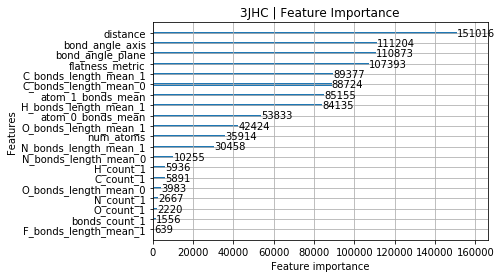

Predicting for: 3JHN
*** Training Model for 3JHN ***
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.2391	valid_1's l1: 0.336335
[1000]	training's l1: 0.182861	valid_1's l1: 0.330838
[1500]	training's l1: 0.146343	valid_1's l1: 0.328034
[2000]	training's l1: 0.118762	valid_1's l1: 0.327098
Early stopping, best iteration is:
[2136]	training's l1: 0.112471	valid_1's l1: 0.326883
[0.880802 0.846898 3.58088  ... 0.349526 0.761158 0.077979]
[0.80004161 0.82642152 3.50932177 ... 1.69959426 0.84740903 0.38286382]
3JHN Fold 0, logMAE: -1.1181534631206858


<Figure size 432x288 with 0 Axes>

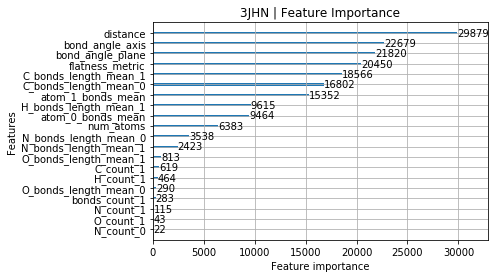

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.237772	valid_1's l1: 0.336397
[1000]	training's l1: 0.182108	valid_1's l1: 0.329479
[1500]	training's l1: 0.145009	valid_1's l1: 0.327456
[2000]	training's l1: 0.117847	valid_1's l1: 0.326371
Early stopping, best iteration is:
[2064]	training's l1: 0.114724	valid_1's l1: 0.326191
[ 1.61132   2.00674  -0.208457 ...  3.27364  -0.133769 -0.006526]
[1.49920719 2.1370075  0.0257112  ... 0.73037993 0.00581382 0.0115073 ]
3JHN Fold 1, logMAE: -1.1202719404675905


<Figure size 432x288 with 0 Axes>

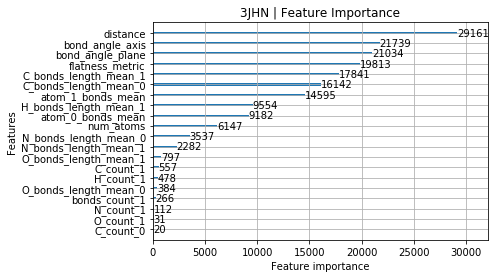

<Figure size 432x288 with 0 Axes>

In [57]:
cv_scores = {}

for coupling_type in COUPLING_TYPES:
    print(f'Predicting for: {coupling_type}')
    cv_score, submission = train_and_predict(coupling_type, submission)
    cv_scores[coupling_type] = cv_score

# Submission

In [58]:
submission = submission.set_index('id')

In [59]:
submission.head()

,scalar_coupling_constant
id,
4658147,15.977512
4658148,199.252472
4658149,1.810719
4658150,199.252472
4658151,15.977512


In [60]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 